## BTC-USD Time Series Forecasting
A time series is a sequence where a metric is recorded over regular time intervals.

Depending on the frequency, a time series can be of yearly (ex: annual budget), quarterly (ex: expenses), monthly (ex: air traffic), weekly (ex: sales qty), daily (ex: weather), hourly (ex: stocks price), minutes (ex: inbound calls in a call canter) and even seconds wise (ex: web traffic).

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/?utm_content=cmp-true#google_vignette

**Forecasting is the next step where you want to predict the future values the series is going to take.**

But why forecast?

Because, forecasting a time series (like demand and sales) is often of tremendous commercial value.
In most manufacturing companies, it drives the fundamental business planning, procurement and production activities. Any errors in the forecasts will ripple down throughout the supply chain or any business context for that matter. So it’s important to get the forecasts accurate in order to save on costs and is critical to success. Not just in manufacturing, the techniques and concepts behind time series forecasting are applicable in any business.

Forecasting a time series can be divided into two types.

**- Univariate Time Series Forecasting:** If you use only the previous values of the time series to predict its future values, it is called 

**- Multi Variate Time Series Forecasting:** If you use predictors other than the series (a.k.a exogenous variables) to forecast it is called 



## Introduction to ARIMA Models
So what exactly is an ARIMA model?

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the **lagged forecast errors**, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: p, d, q where,
- p is the order of the AR term
- q is the order of the MA term
- d is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

**The first step to build an ARIMA model is to make the time series stationary.**

Why?

Because, term ‘Auto Regressive’ in ARIMA means it is a linear regression model that uses its own lags as predictors. **Linear regression models, as you know, work best when the predictors are not correlated and are independent of each other.**

**How to make a series stationary? How to determiine 'd'?**

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.
The value of d, therefore, is the minimum number of differencing needed to make the series stationary. And if the time series is already stationary, then d = 0.


**Next, what are the ‘p’ and ‘q’ terms?**

‘p’ is the order of the ‘Auto Regressive’ (AR) term. It refers to the number of lags of Y to be used as predictors.

‘q’ is the order of the ‘Moving Average’ (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

## What are AR and MA models?

What is the actual mathematical formula for the AR and MA models?

A pure **Auto Regressive (AR only) model** is one where $Y_t$ depends only on its own lags. That is, $Y_t$ is a function of the 'lags of $Y_t$'.

$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + \epsilon_1$

where, $Y_{t-1}$ is the lag1 of the series, $\beta_1$ is the coefficient of lag1 that the model estimates and `alpha` is the intercept term, also estimated by the model.

Likewise a pure **Moving Average (MA only) model** is one where $Y_t$ depends only on the lagged forecast errors.

$Y_t = \alpha + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \ldots + \phi_q \epsilon_{t-q}$

where the error terms are the errors of the **Auto Regressive (AR only) model** of the respective lags. The errors $\epsilon_t$ and $\epsilon_{t-1}$ are the errors from the following equations:

$Y_t = \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_0 Y_0 + \epsilon_t$

$Y_{t-1} = \beta_2 Y_{t-2} + \beta_3 Y_{t-3} + \ldots + \beta_0 Y_0 + \epsilon_{t-1}$


**So what does the equation of an ARIMA model look like?**

An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:

$Y_t = \alpha + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + \ldots + \beta_p Y_{t-p} + \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_2 \epsilon_{t-2} + \ldots + \phi_q \epsilon_{t-q}$  (we kept p term from the AR model a q term from the MA model)


#### Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)


## How to find the order of differencing (d) in ARIMA model
The purpose of differencing it to make the time series stationary.

But you need to be careful to not over-difference the series. Because, an over differenced series may still be stationary, which in turn will affect the model parameters.

**The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.**

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

First, I am going to check if the series is stationary using the Augmented Dickey Fuller test (adfuller()), from the statsmodels package.
You need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

**The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore FutureWarnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)  # Ignore performance warnings if any
warnings.filterwarnings("ignore", message="No frequency information was provided")  # Ignore frequency warnings from statsmodels



In [4]:
def fill_gaps_with_interpolation(df, col, expected_freq):
    """
    Fills gaps in the DataFrame using linear interpolation, based on the expected frequency.
    Ensures 'time_period_start' is in datetime format and 'id' is the index.

    Parameters:
        df (pd.DataFrame): The DataFrame to be interpolated.
        expected_freq (str): The frequency string indicating the expected interval between rows.

    Returns:
        pd.DataFrame: The interpolated DataFrame with gaps filled.
    """
    df[col] = pd.to_datetime(df[col], utc=True)
    df_temp = df.set_index(col)
    expected_freq = expected_freq.replace('HRS', 'h').replace('MIN', 'min')
    full_index = pd.date_range(start=df_temp.index.min(), end=df_temp.index.max(), freq=expected_freq)
    df_reindexed = df_temp.reindex(full_index)
    df_reindexed['is_interpolated'] = df_reindexed.isna().any(axis=1)
    df_interpolated = df_reindexed.interpolate(method='linear')
    df_interpolated.reset_index(inplace=True)
    df_interpolated.rename(columns={'index': col}, inplace=True)

    return df_interpolated

In [5]:
df = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_1HRS.csv", parse_dates=['time_period_end'])
df = fill_gaps_with_interpolation(df, 'time_period_end','1HRS')
df = df[['time_period_end', 'price_close']].rename(columns={'time_period_end': 'date', 'price_close': 'value'})
df['date'] = df['date'].dt.tz_convert(None)
df = df[(df['date'] >= '2024-05-20') & (df['date'] <= '2024-12-31')]
#df.set_index('date', inplace=True)

df

,date,value
10703,2024-05-20 00:00:00,66257.90
10704,2024-05-20 01:00:00,66448.96
10705,2024-05-20 02:00:00,66524.68
10706,2024-05-20 03:00:00,66664.39
10707,2024-05-20 04:00:00,66679.17
...,...,...
10867,2024-05-26 20:00:00,68864.96
10868,2024-05-26 21:00:00,68680.91
10869,2024-05-26 22:00:00,68495.63
10870,2024-05-26 23:00:00,68526.05


In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.486157
p-value: 0.118879


Since P-value is greater than the significance level (non stationary), let’s difference the series and see how the autocorrelation plot looks like.

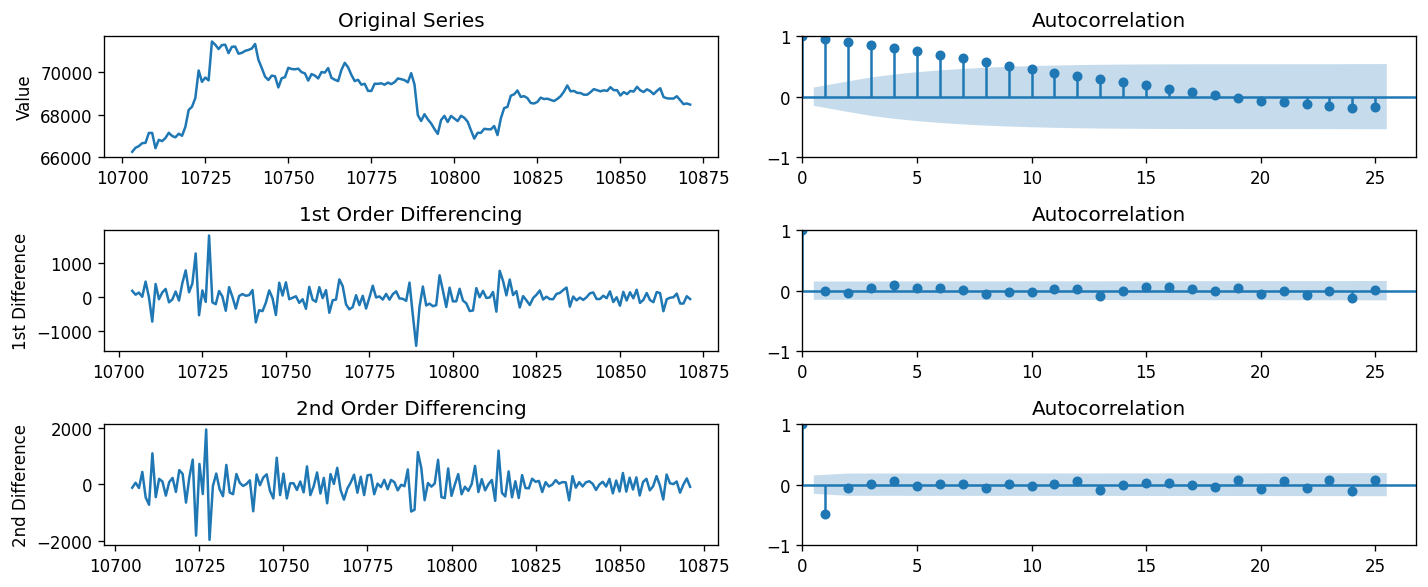

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import pandas as pd


plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':120})

# Calculating differences
df['value_diff1'] = df['value'].diff()  # First difference
df['value_diff2'] = df['value_diff1'].diff()  # Second difference

# Create subplots
fig, axes = plt.subplots(3, 2)


# Original Series
axes[0, 0].plot(df['value'])
axes[0, 0].set_title('Original Series')
axes[0, 0].set_ylabel('Value')
plot_acf(df['value'].dropna(), ax=axes[0, 1], lags=25)
axes[0, 1].set_xlim(left=0)  # Adjust according to your autocorrelation lags

# 1st Differencing
axes[1, 0].plot(df['value_diff1'])
axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].set_ylabel('1st Difference')
plot_acf(df['value_diff1'].dropna(), ax=axes[1, 1], lags=25)
axes[1, 1].set_xlim(left=0)  # Adjust according to your autocorrelation lags

# 2nd Differencing
axes[2, 0].plot(df['value_diff2'])
axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].set_ylabel('2nd Difference')
plot_acf(df['value_diff2'].dropna(), ax=axes[2, 1], lags=25)
axes[2, 1].set_xlim(left=0)  # Adjust according to your autocorrelation lags

# Show the plots
plt.tight_layout()
plt.show()


For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

## Unit root test ndiffs
The ndiffs function from the pmdarima (also known as statsmodels) library is used to determine the number of differences needed to make a time series stationary. 

In [8]:
from pmdarima.arima.utils import ndiffs

y = df.value

## Adf Test
print(ndiffs(y, test='adf')) 

# KPSS test
print(ndiffs(y, test='kpss'))  

# PP test:
print(ndiffs(y, test='pp'))  


1
0
1


**Interpretation:**

If all three tests (ADF, KPSS, PP) return 1, it suggests a strong consensus that the time series is non-stationary and requires first-order differencing to achieve stationarity. 
This is a good indication that differencing the series once will help in removing trends and seasonality, making it suitable for modeling, for example, with ARIMA or other time series models.

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import q_stat

# Perform Ljung-Box test
ljung_box_result = acorr_ljungbox(df['value'].diff().dropna(), lags=[10], return_df=True)

print(ljung_box_result)

     lb_stat  lb_pvalue
10  3.667621   0.961098


It seems that it is not a white noise accordingly to the test

## How to find the order of the AR term (p)
The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

**But what is PACF?**

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

What is the formula for PACF mathematically?
$Y_t = \alpha_0 + \alpha_1 Y_{t-1} + \alpha_2 Y_{t-2} + \alpha_3 Y_{t-3}$


Partial autocorrelation of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

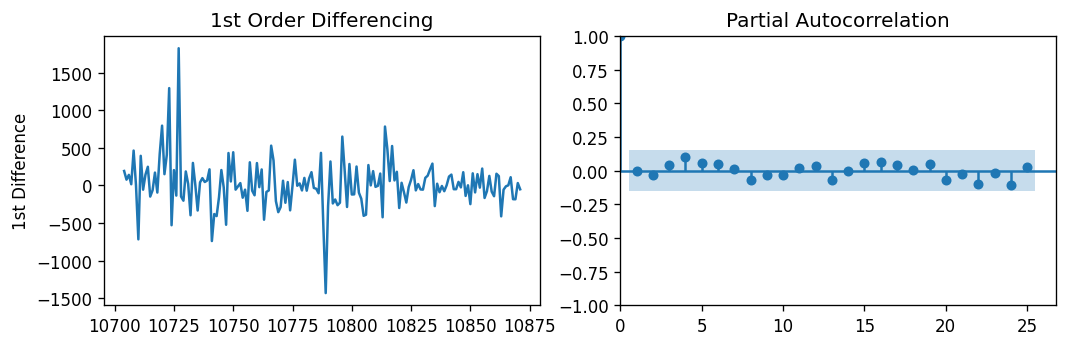

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

# Updating plot configurations
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Creating subplots
fig, axes = plt.subplots(1, 2)

# Calculating differences
df['value_diff1'] = df['value'].diff()  # First difference

# 1st Differencing
axes[0].plot(df['value_diff1'])
axes[0].set_title('1st Order Differencing')
axes[0].set_ylabel('1st Difference')

# Plotting the PACF
plot_pacf(df['value_diff1'].dropna(), ax=axes[1], lags=25)
axes[1].set_xlim(left=0)  # Adjust according to your autocorrelation lags

# Show the plots
plt.tight_layout()
plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line. Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region). But I am going to be conservative and tentatively fix the p as 1.


## How to find the order of the MA term (q)
Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.


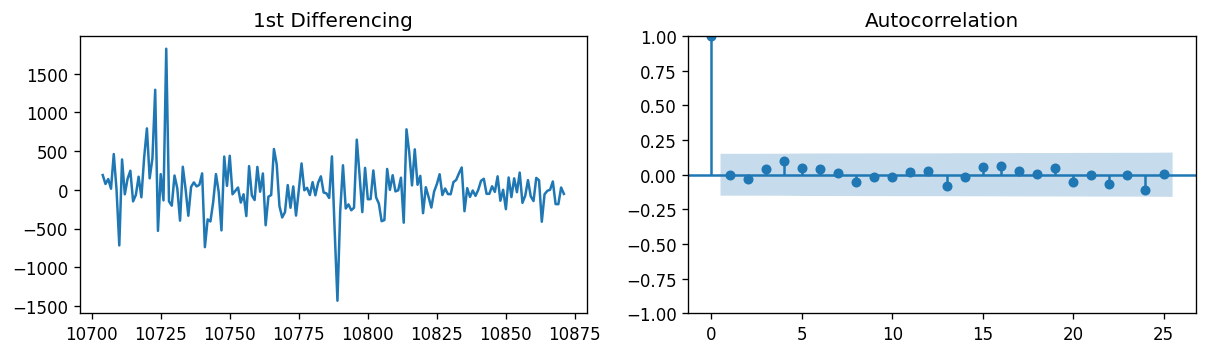

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(12,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(df.value.diff()), axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), lags=25, ax=axes[1])

plt.show()

Idea : Couple of lags are well above the significance line. So, let’s tentatively fix q as 2. When in doubt, go with the simpler model that sufficiently explains the Y.

Here we can put q=0

## How to handle if a time series is slightly under or over differenced
It may so happen that your series is slightly under differenced, that differencing it one more time makes it slightly over-differenced.

**How to handle this case?**

If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

## How to build the ARIMA Model
Now that you’ve determined the values of p, d and q, you have everything needed to fit the ARIMA model. Let’s use the ARIMA() implementation in statsmodels package.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  169
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1209.820
Date:                Tue, 02 Jul 2024   AIC                           2423.640
Time:                        10:13:25   BIC                           2429.888
Sample:                             0   HQIC                          2426.176
                                - 169                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0212      0.064      0.330      0.742      -0.105       0.147
sigma2      1.054e+05   5190.393     20.307      0.000    9.52e+04    1.16e+05
Ljung-Box (L1) (Q):                   0.08   Jarque-

c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


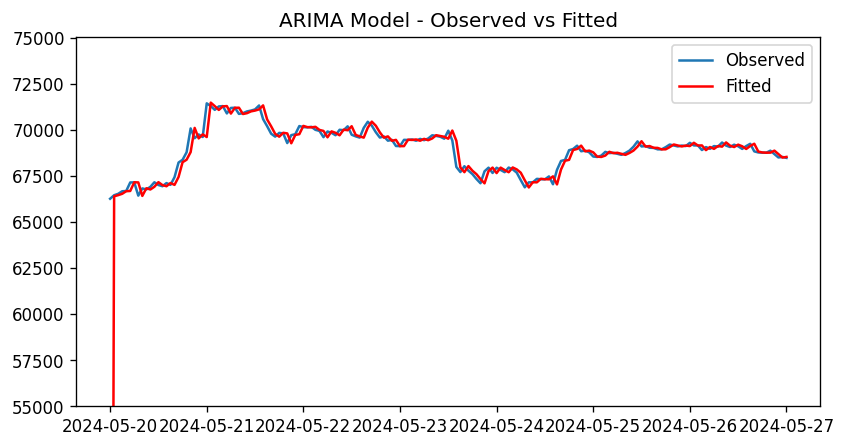

In [12]:
from statsmodels.tsa.arima.model import ARIMA


# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,0))
model_fit = model.fit()
print(model_fit.summary())


# Plot the forecasts
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df['date'], df['value'], label='Observed')
ax.plot(df['date'], model_fit.fittedvalues, color='red', label='Fitted')
ax.set_title('ARIMA Model - Observed vs Fitted')
ax.legend()
ax.set_ylim(bottom=55000)
plt.show()

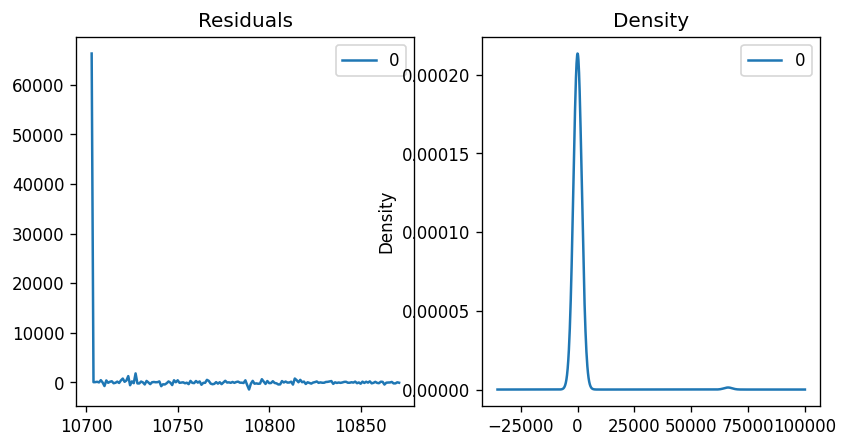

In [13]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(8, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance. Let’s plot the actuals against the fitted values using plot_predict()

c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


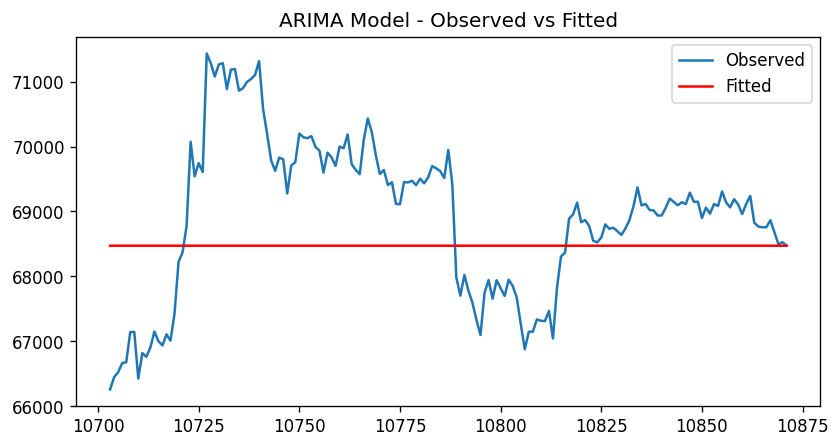

In [14]:
n = len(df)  # Number of observations
forecast = model_fit.get_forecast(steps=n)
predicted_mean_values = forecast.predicted_mean

# Since 'predicted_mean_values' might not have a datetime index, ensure 'df['date']' is used correctly.
# Also, it's crucial to ensure the lengths of 'df['date']' and 'predicted_mean_values' match.
# Convert 'predicted_mean_values' to a series with 'df['date']' as its index if needed.

# Plot the forecasts
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df.index, df['value'], label='Observed')
ax.plot(df.index, predicted_mean_values, color='red', label='Fitted')
ax.set_title('ARIMA Model - Observed vs Fitted')

ax.legend()

plt.show()

## How to do find the optimal ARIMA model manually using Out-of-Time Cross validation
In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Why am I not sampling the training data randomly you ask?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.

c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


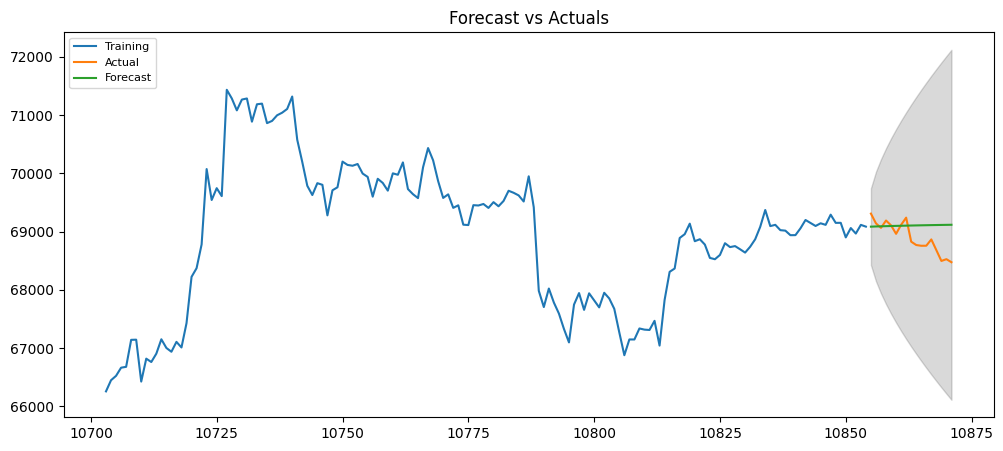

In [15]:
from statsmodels.tsa.arima.model import ARIMA

# Train-test split
train_size = int(len(df) * 0.9)
train, test = df['value'][:train_size], df['value'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(3, 1, 1))
fitted = model.fit()

# Forecast
forecast_steps = len(test)
forecast = fitted.get_forecast(steps=forecast_steps)
fc_series = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, fc_series, label='Forecast')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

So, what I am going to do is to increase the order of differencing to two, that is set d=2 and iteratively increase p to up to 5 and then q up to 5 to see which model gives least AIC and also look for a chart that gives closer actuals and forecasts.

While doing this, I keep an eye on the P values of the AR and MA terms in the model summary. They should be as close to zero, ideally, less than 0.05

The AIC has reduced to 440 from 515. Good. The P-values of the X terms are less the < 0.05, which is great.

So overall it’s much better.

Ideally, you should go back multiple points in time, like, go back 1, 2, 3 and 4 quarters and see how your forecasts are performing at various points in the year.

## Accuracy Metrics for Time Series Forecast
The commonly used accuracy metrics to judge forecasts are:

- Mean Absolute Percentage Error (MAPE)
- Mean Error (ME)
- Mean Absolute Error (MAE)
- Mean Percentage Error (MPE)
- Root Mean Squared Error (RMSE)
- Correlation between the Actual and the Forecast (corr)
- Min-Max Error (minmax)

Typically, if you are comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.

Why not use the other metrics?

Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.

The other error metrics are quantities. That implies, an RMSE of 100 for a series whose mean is in 1000’s is better than an RMSE of 5 for series in 10’s. So, you can’t really use them to compare the forecasts of two different scaled time series.

In [16]:
# Apply the forecast_accuracy function
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)  # Ensure forecast is a NumPy array
    actual = np.array(actual)      # Ensure actual is a NumPy array
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)                            # ME
    mae = np.mean(np.abs(forecast - actual))                   # MAE
    mpe = np.mean((forecast - actual) / actual)                # MPE
    rmse = np.mean((forecast - actual)**2)**0.5                # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]                  # corr
    mins = np.amin(np.hstack([forecast[:, None], 
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None], 
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins / maxs)                          # minmax

    return {'mape': mape, 'me': me, 'mae': mae, 
            'mpe': mpe, 'rmse': rmse, 
            'corr': corr, 'minmax': minmax}


# Calculate accuracy metrics
accuracy_metrics = forecast_accuracy(fc_series,  test.values)
print(accuracy_metrics)

{'mape': 0.003887566679217696, 'me': 203.92657724993907, 'mae': 267.15204105638855, 'mpe': 0.0029744642297449674, 'rmse': 336.46271345036405, 'corr': -0.895324855501312, 'minmax': 0.0038646987504080688}


## How to do Auto Arima Forecast in Python
Like R’s popular auto.arima() function, the pmdarima package provides auto_arima() with similar functionality.

auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [17]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2425.412, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2423.609, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2425.404, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2425.445, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2421.886, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.274 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  169
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1209.943
Date:                Tue, 02 Jul 2024   AIC                           2421.886
Time:                        10:13:30   BIC                           2425.010
Sample:                             0   HQIC                          2423.154
                                - 169                                       

## How to interpret the residual plots in ARIMA model

Let’s review the residual plots using stepwise_fit.

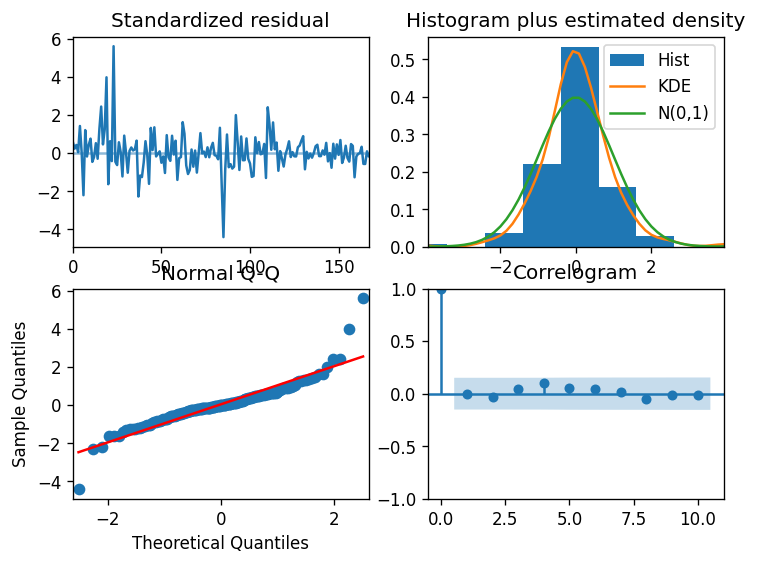

In [18]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

So how to interpret the plot diagnostics?

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero. but not the same variance

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed. Here it is skewed

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s forecast.

[10872 10873 10874 10875 10876 10877 10878 10879 10880 10881 10882 10883
 10884 10885 10886 10887 10888 10889 10890 10891 10892 10893 10894 10895
 10896 10897 10898 10899 10900 10901 10902 10903 10904 10905 10906 10907
 10908 10909 10910 10911 10912 10913 10914 10915 10916 10917 10918 10919
 10920 10921]


c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


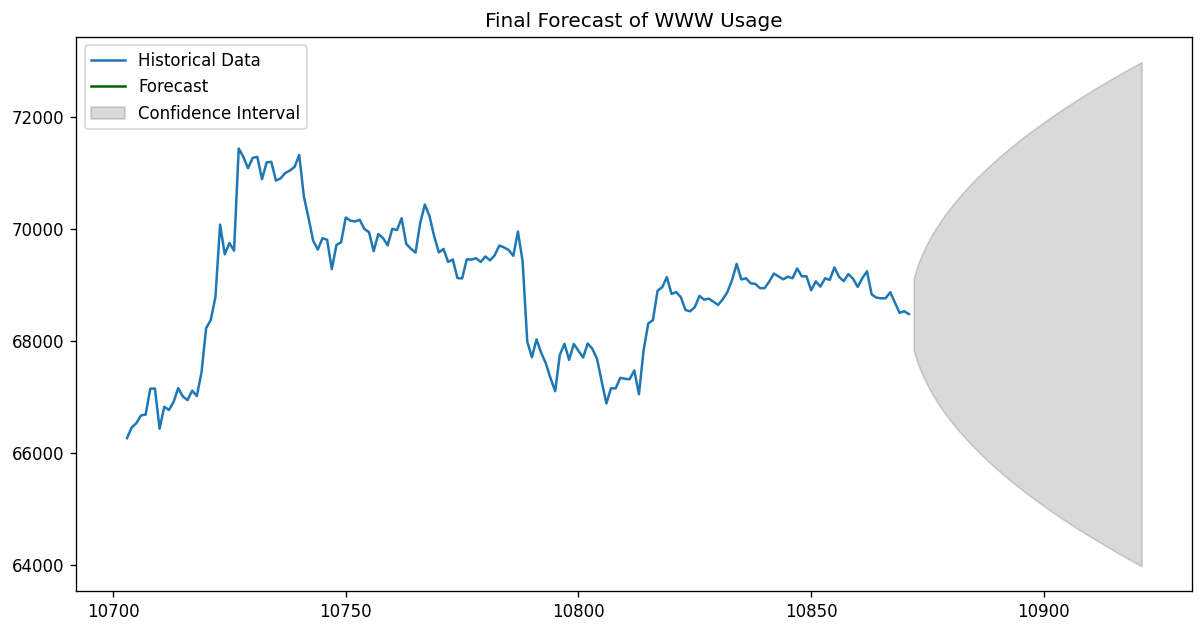

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure your model is correctly defined and df is your DataFrame containing the historical data.
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

last_index_value = df.index[-1] +1
index_of_fc = np.arange(last_index_value, last_index_value + n_periods)
print(index_of_fc)


fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], label='Historical Data')
plt.plot(index_of_fc, fc_series, color='darkgreen', label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15, label='Confidence Interval')

plt.title("Final Forecast of WWW Usage")
plt.legend(loc='upper left')
plt.show()

## Walk Forward Validation


C:\Users\SolalDanan\AppData\Local\Temp\ipykernel_1800\3958445776.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f, previous=%f' % (yhat, obs, history[-2]))


predicted=66682.199177, expected=66722.050000, previous=66670.340000
predicted=0.000000, expected=1.000000
predicted=66706.967269, expected=66590.360000, previous=66722.050000
predicted=1.000000, expected=-1.000000
predicted=66602.614767, expected=66043.730000, previous=66590.360000
predicted=-1.000000, expected=-1.000000
predicted=66031.608089, expected=66162.740000, previous=66043.730000
predicted=-1.000000, expected=1.000000
predicted=66147.406055, expected=66270.970000, previous=66162.740000
predicted=1.000000, expected=1.000000
predicted=66261.994941, expected=66363.240000, previous=66270.970000
predicted=1.000000, expected=1.000000
predicted=66356.166249, expected=66257.900000, previous=66363.240000
predicted=1.000000, expected=-1.000000
predicted=66252.361244, expected=66448.960000, previous=66257.900000
predicted=-1.000000, expected=1.000000
predicted=66446.794121, expected=66524.680000, previous=66448.960000
predicted=1.000000, expected=1.000000
predicted=66522.787957, expecte

c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=68788.694433, expected=70072.050000, previous=68778.350000
predicted=1.000000, expected=1.000000
predicted=70068.261923, expected=69541.500000, previous=70072.050000
predicted=1.000000, expected=-1.000000
predicted=69576.837512, expected=69744.270000, previous=69541.500000
predicted=-1.000000, expected=1.000000
predicted=69786.064521, expected=69607.960000, previous=69744.270000
predicted=1.000000, expected=-1.000000
predicted=69657.581822, expected=71432.170000, previous=69607.960000
predicted=-1.000000, expected=1.000000
predicted=71425.307264, expected=71283.640000, previous=71432.170000
predicted=1.000000, expected=-1.000000
predicted=71331.898004, expected=71079.240000, previous=71283.640000
predicted=-1.000000, expected=-1.000000
predicted=71094.416448, expected=71264.420000, previous=71079.240000
predicted=-1.000000, expected=1.000000
predicted=71298.623391, expected=71283.120000, previous=71264.420000
predicted=1.000000, expected=1.000000
predicted=71315.615322, expec

c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=68980.087809, expected=69135.520000, previous=68955.200000
predicted=1.000000, expected=1.000000
predicted=69126.630966, expected=68834.100000, previous=69135.520000
predicted=1.000000, expected=-1.000000
predicted=68852.895230, expected=68868.150000, previous=68834.100000
predicted=-1.000000, expected=1.000000
predicted=68872.160280, expected=68776.680000, previous=68868.150000
predicted=1.000000, expected=-1.000000
predicted=68786.945389, expected=68547.800000, previous=68776.680000
predicted=-1.000000, expected=-1.000000
predicted=68554.103704, expected=68525.130000, previous=68547.800000
predicted=-1.000000, expected=-1.000000
predicted=68526.296225, expected=68598.630000, previous=68525.130000
predicted=-1.000000, expected=1.000000
predicted=68600.100074, expected=68800.000000, previous=68598.630000
predicted=1.000000, expected=1.000000
predicted=68800.546678, expected=68733.190000, previous=68800.000000
predicted=1.000000, expected=-1.000000
predicted=68740.144630, expe

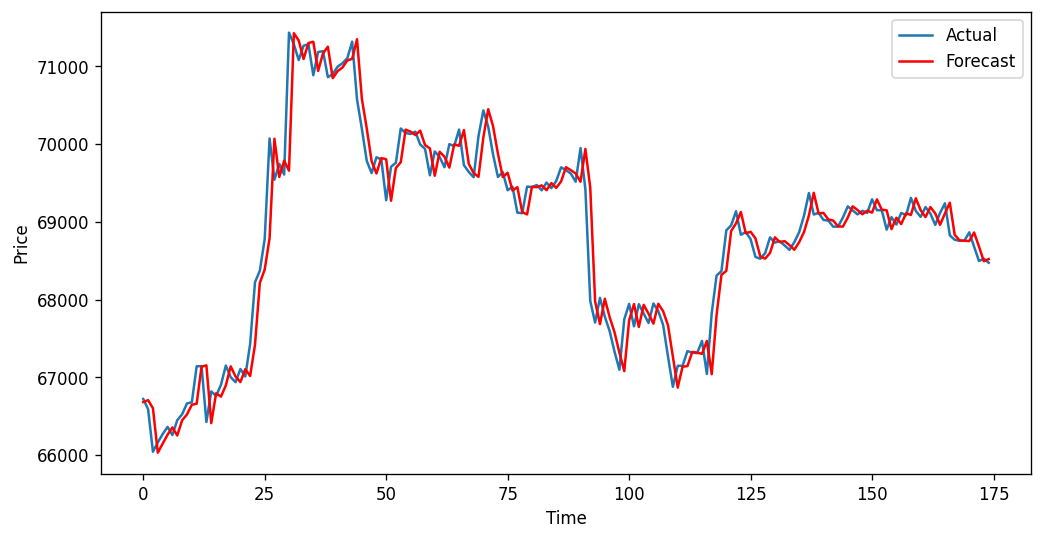

In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA

# Derebit Data

# df = pd.read_parquet('C:/Users/Dimitri/Documents/GitHub/Indicators/Code/Data/eth_usd_derebit.parquet')
df = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_1HRS.csv", parse_dates=['time_period_end'])
df = fill_gaps_with_interpolation(df, 'time_period_end', '1HRS')
ohlc = df[['time_period_end', 'price_close']].rename(columns={'time_period_end': 'time_close', 'price_close': 'Close'})


ohlc['time_close'] = pd.to_datetime(ohlc['time_close'])
ohlc = ohlc.rename(columns={'time_close':'timestamp'})
ohlc = ohlc.set_index('timestamp')
close_series = ohlc[['Close']]
close_series = close_series[10000:]
close_series


# split into train and test sets
X = close_series.values

#--data_split is a hyperparam
size = int(len(X) * 0.8)
#--
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []
pred_directions = []
actu_directions = []


# walk-forward validation
for t in range(len(test)):
	#hyperparams- p d q 
	model = ARIMA(history, order=(2,1,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	# Cas Specific pr le 1er prediction
	if len(predictions) < 2:
		pred_direction = 0
	else:
		pred_direction = 1 if len(predictions) > 1 and predictions[-2] < predictions[-1] else -1
	actu_direction = 1 if len(history)> 1 and history[-2] < history[-1] else -1
	actu_directions.append(actu_direction)
	pred_directions.append(pred_direction)

	print('predicted=%f, expected=%f, previous=%f' % (yhat, obs, history[-2]))
	print('predicted=%f, expected=%f' % (pred_direction, actu_direction))


rmse = np.sqrt(mean_squared_error(test, predictions))
mape = mean_absolute_percentage_error(test, predictions, multioutput='raw_values')[0]
r2 = r2_score(test, predictions, multioutput='raw_values')[0]
num_matches = sum(pred == actual for pred, actual in zip(pred_directions, actu_directions))
directional_accuracy = num_matches/len(test)


print(f'Test RMSE: {rmse:.3f}')
print(f'MAPE: {mape:.3f}%')
print(f'R² Score: {r2:.3f}')
print(f'Directional Accuracy: {directional_accuracy:.3f}%')


plt.figure(figsize=(10, 5))
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='Forecast')
plt.legend()
plt.show()

In [86]:
df = pd.read_csv("C:/Users/SolalDanan/Trading Signal/1years_ohlcv_btc_usd_spot_4HRS.csv", parse_dates=['time_period_end'])
df = fill_gaps_with_interpolation(df, 'time_period_end',  '4HRS')
ohlc = df[['time_period_end', 'price_close']].rename(columns={'time_period_end': 'time_close', 'price_close': 'close'})


ohlc['time_close'] = pd.to_datetime(ohlc['time_close'])
ohlc = ohlc.rename(columns={'time_close':'timestamp'})
ohlc = ohlc.set_index('timestamp')
df_close = pd.DataFrame(ohlc['close'], index=ohlc.index)
df_close


max_index = len(df_close) - 155  # Ensuring k does not exceed the length of df_close
if max_index > 0:
    j = np.random.choice(np.arange(max_index))
    k = j + 155
else:
    raise ValueError("The dataset is not large enough to support the chosen slice size of 132.")

# Now slice the DataFrame
df_slice = df_close.iloc[j:k]
if df_slice.empty:
    raise ValueError("The resulting slice is empty. Adjust the indices.")

# How far in fuure we want to predict - 15hrs 
n_pred = 15 # Define the number of periods to forecast

# Arima params
p = 3
d = 1
q = 1


# Assuming df_close is already loaded and contains a 'close' column
print("Data shape before slicing:", df_close.shape)
df_close = df_close[j:k]  # Make sure j and k are correctly defined
print("Data shape after slicing:", df_close.shape)

if df_close.empty:
    raise ValueError("Selected data slice is empty. Adjust the indices j and k.")

size = int(len(df_close) * 0.80)
train = df_close['close'][0:size]
test = df_close['close'][size:len(df_close)]

if len(train) < 1:
    raise ValueError("Training set is empty. Check your data slice and size calculation.")


# Fit ARIMA model
model = ARIMA(train, order=(p, d, q))
fitted = model.fit()

# Plot residuals
'''
residuals = pd.DataFrame(fitted.resid)
plt.figure(figsize=(12, 6))
residuals.plot(title="Residuals")
residuals.plot(kind='kde', title="Density of Residuals")
plt.show()

# Statistics on residuals
print(residuals.describe())
'''

pred_result = fitted.get_forecast(steps=n_pred).summary_frame()

Data shape before slicing: (2718, 1)
Data shape after slicing: (155, 1)


c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency 4h will be used.

c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency 4h will be used.

c:\Users\SolalDanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency 4h will be used.



In [87]:
import plotly.graph_objects as go


pred_idx = test[:n_pred].index
pred_result.index = pred_idx
combined_df = pd.concat([df_close, pred_result])

first_pred = test.index[0]
last_pred = test.index[-1]
ohlc_compar = ohlc.loc[first_pred:last_pred]
df_compar = pd.concat([ohlc_compar, pred_result], axis=1)
df_compar = df_compar.head(n_pred)


fig = go.Figure()

fig.add_trace(go.Scatter(x=df_close.index, y=df_close['close'], mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=pred_result.index, y=pred_result['mean'], mode='lines', name='Predicted Mean'))
fig.add_trace(go.Scatter(x=pred_result.index, y=pred_result['mean_ci_lower'], mode='lines', name='Predicted LO'))
fig.add_trace(go.Scatter(x=pred_result.index, y=pred_result['mean_ci_upper'], mode='lines', name='Predicted Hi'))

direction = (df_compar['mean'][-1] - df_compar['mean'][0])

# Set axis labels and title
fig.update_layout(
    xaxis_title='Time',
    yaxis_title='Price',
    title='Actual Price vs. Predicted Mean')


fig.add_annotation(
    x=1,
    y=1,
    xref="paper",
    yref="paper",
    text=f"Direction: {direction:.2f}",
    showarrow=False,
    xanchor='right',
    yanchor='top',
    font=dict(
        size=12,
        color="black"
    ),
    align="right")


fig.show()

pred_result
print(train.index[-1])
print(train.iloc[-1])

2023-10-29 16:00:00+00:00
34465.52


## SARIMAX model in python

**The problem with plain ARIMA model is it does not support seasonality.**

If your time series has defined seasonality, then, go for SARIMA which uses seasonal differencing.

Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.

So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.

If your model has well defined seasonal patterns, then enforce D=1 for a given frequency ‘x’.

Here’s some practical advice on building SARIMA model:

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR or SMA terms if your model has seasonal components.

X stands for exogenous variable that coulld improve the predictions

https://github.com/dushyant18033/BTC-Price-Prediction-ML-Project/tree/master